In [12]:
import cv2
import os
import time
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Configure kaggle
os.chdir('/root/')
!mkdir -p .kaggle
os.chdir('/root/.kaggle')
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Y-o0TVcjehM8SZB3Nt8U3xkyeQu-Nse-' -O kaggle.json > /dev/null 2>&1
!ls /root/.kaggle

# Set permissions 
!chmod 600 /root/.kaggle/kaggle.json

# Create data folder
os.chdir('/content/')

In [6]:
# Download data
!pip install -q kaggle
!kaggle datasets download -d rupakroy/handpose-detection

 98% 129M/131M [00:01<00:00, 76.5MB/s]
100% 131M/131M [00:01<00:00, 72.3MB/s]


In [ ]:
!unzip '/content/handpose-detection.zip' -d '/content/dataset/'

In [9]:
protoFile = "/content/dataset/hand/pose_deploy.prototxt"
weightsFile = "/content/dataset/hand/pose_iter_102000.caffemodel"

In [10]:
nPoints = 22
POSE_PAIRS = [ [0,1],[1,2],[2,3],[3,4],[0,5],[5,6],[6,7],[7,8],[0,9],[9,10],[10,11],[11,12],[0,13],[13,14],[14,15],[15,16],[0,17],[17,18],[18,19],[19,20] ]
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

In [18]:
frame = cv2.imread("/content/dataset/hand.jpg")
frameCopy = np.copy(frame)
frameWidth = frame.shape[1]
frameHeight = frame.shape[0]
aspect_ratio = frameWidth/frameHeight
threshold = 0.1

t = time.time()
# input image dimensions for the network
inHeight = 368
# inWidth = 368
inWidth = int(((aspect_ratio*inHeight)*8)//8)
inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                          (0, 0, 0), swapRB=False, crop=False)

net.setInput(inpBlob)

output = net.forward()
print("time taken by network : {:.3f}".format(time.time() - t))

time taken by network : 7.187


In [19]:
%matplotlib inline
for i in range(22):
    probMap = output[0, i, :, :]
    probMap = cv2.resize(probMap, (frame.shape[1], frame.shape[0]))
    plt.figure(figsize=[14,10])
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.imshow(probMap, alpha=0.6)
    plt.colorbar()
    plt.axis("off")

Output hidden; open in https://colab.research.google.com to view.

Total time taken : 34.714


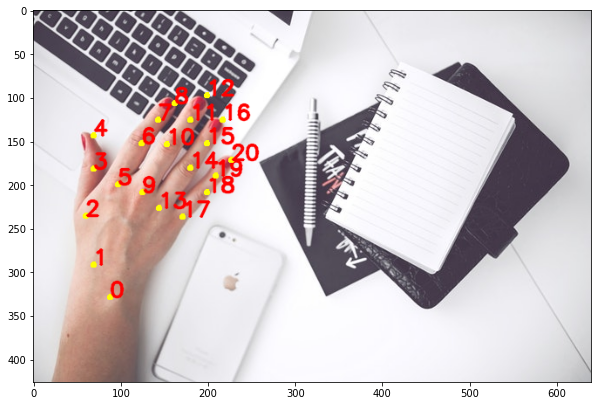

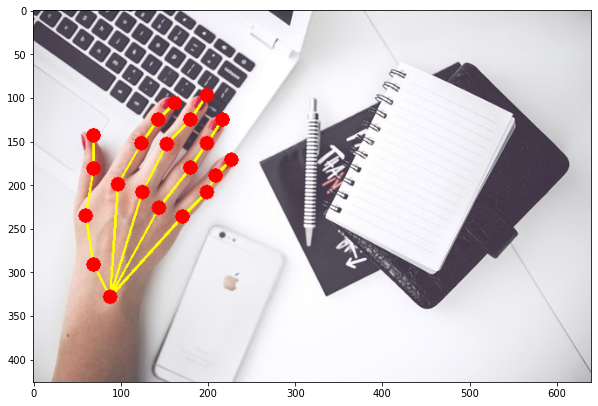

In [20]:
# Empty list to store the detected keypoints
points = []

for i in range(nPoints):
    # confidence map of corresponding body's part.
    probMap = output[0, i, :, :]
    probMap = cv2.resize(probMap, (frameWidth, frameHeight))

    # Find global maxima of the probMap.
    minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)

    if prob > threshold :
        cv2.circle(frameCopy, (int(point[0]), int(point[1])), 3, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
        cv2.putText(frameCopy, "{}".format(i), (int(point[0]), int(point[1])), cv2.FONT_HERSHEY_SIMPLEX, .8, (0, 0, 255), 2, lineType=cv2.LINE_AA)

        # Add the point to the list if the probability is greater than the threshold
        points.append((int(point[0]), int(point[1])))
    else :
        points.append(None)

# Draw Skeleton
for pair in POSE_PAIRS:
    partA = pair[0]
    partB = pair[1]

    if points[partA] and points[partB]:
        cv2.line(frame, points[partA], points[partB], (0, 255, 255), 2)
        cv2.circle(frame, points[partA], 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)
        cv2.circle(frame, points[partB], 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)


plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(frameCopy, cv2.COLOR_BGR2RGB))
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))


cv2.imwrite('./Output-Keypoints.jpg', frameCopy)
cv2.imwrite('./Output-Skeleton.jpg', frame)

print("Total time taken : {:.3f}".format(time.time() - t))